In [1]:
!pip install qiskit

In [2]:
!pip install python-resize-image

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import matplotlib.pyplot as plt
from resizeimage import resizeimage
from PIL import Image

import frqi
import quantum_edge_detection as qed

In [3]:
simulator = Aer.get_backend('qasm_simulator')
#Backends are available trough two providers. 
#Aer and IBMQ. Aer provides simulators, while IBMQ provides physical hardware access through cloud.
#in this work we choose the work on the qasm_simulator.
#qasm_simulator allows ideal and noisy multi-shot execution of qiskit circuits and returns counts or memory.


In [4]:
# Setup the Circuit
anc = QuantumRegister(1, "anc")
#anc=Ancilla bit
img = QuantumRegister(11, "img")
anc2 = QuantumRegister(1, "anc2")
c = ClassicalRegister(12)

qc = QuantumCircuit(anc, img, anc2, c)
print(qc)


           
 anc_0: |0>
           
 img_0: |0>
           
 img_1: |0>
           
 img_2: |0>
           
 img_3: |0>
           
 img_4: |0>
           
 img_5: |0>
           
 img_6: |0>
           
 img_7: |0>
           
 img_8: |0>
           
 img_9: |0>
           
img_10: |0>
           
anc2_0: |0>
           
   c0_0: 0 
           
   c0_1: 0 
           
   c0_2: 0 
           
   c0_3: 0 
           
   c0_4: 0 
           
   c0_5: 0 
           
   c0_6: 0 
           
   c0_7: 0 
           
   c0_8: 0 
           
   c0_9: 0 
           
  c0_10: 0 
           
  c0_11: 0 
           


In [10]:
imageNames = ["Ref_Tokyo_grayscale.jpg", "Tokyo_grayscale.jpg", "Sapporo_grayscale.jpg"]
imageNum1 = 0
imageNum2 = 2

image1 = Image.open(imageNames[imageNum1]).convert('LA')
#converting JPG to grayscale
image2 = Image.open(imageNames[imageNum2]).convert('LA')

In [11]:
def image_normalization(image):
    image = resizeimage.resize_cover(image, [32, 32])
    w, h = 32, 32
    image = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])

    # 2-dimentional data convert to 1-dimentional array
    image = image.flatten()
    # change type
    image = image.astype('float64')
    # Normalization(0~pi/2)
    image /= 255.0
    generated_image = np.arcsin(image)

    return generated_image

image1 = image_normalization(image1)
image2 = image_normalization(image2)

In [6]:
# apply hadamard gates
for i in range(1, len(img)):
    qc.h(img[i])
print(qc)    

                          
 anc_0: |0>───────────────
                          
 img_0: |0>───────────────
           ┌───┐┌───┐     
 img_1: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_2: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_3: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_4: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_5: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_6: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_7: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_8: |0>┤ H ├┤ H ├─────
           ├───┤├───┤     
 img_9: |0>┤ H ├┤ H ├─────
           ├───┤├───┤┌───┐
img_10: |0>┤ H ├┤ H ├┤ H ├
           └───┘└───┘└───┘
anc2_0: |0>───────────────
                          
   c0_0: 0 ═══════════════
                          
   c0_1: 0 ═══════════════
                          
   c0_2: 0 ═══════════════
                          
   c0_3: 0 ═══════════════
                          
   c0_4: 0 ═══════════════
                          
 

In [13]:
# encode ref image
for i in range(len(image1)):
        if image1[i] != 0:
                frqi.c10ry(qc, 2 * image1[i], format(i, '010b'), img[0], anc2[0], [img[j] for j in range(1,len(img))])
# frqi  allows us to encode an image of size m = n x n (pixels) into log2(m) qubits.
#frqi have taken  https://github.com/Shedka/citiesatnight
ab=qed.quantum_edge_detection(qc)
#apply the  FourierTransformCircuits
qc.measure(anc, c[0])
qc.measure(img, c[1:12])

print(qc.depth())
print(ab)


158091
None


In [13]:
import time
t0 = time.time()

In [15]:
numOfShots = 8192# the number of times the circuit is run can be specified via the shots. 

In [16]:
result = execute(qc, simulator, shots=numOfShots, backend_options={"fusion_enable":True}).result()
duration = time.time() - t0
print('It took %d seconds to execute the circuit using %s' %(duration,simulator))

It took 432 seconds to execute the circuit using qasm_simulator


In [17]:
print(result.get_counts(qc))

{'101000010101': 4, '001110001111': 5, '000101010010': 2, '101011101101': 1, '100011111001': 2, '101101010100': 1, '110000101110': 1, '111101100111': 4, '111001100010': 2, '011010101011': 3, '101011101000': 5, '100100111010': 2, '101100110111': 3, '000010111100': 2, '110100001100': 3, '011101100101': 1, '001010111100': 3, '010111101001': 4, '111011010110': 1, '011011000100': 3, '101110111001': 2, '010101011110': 2, '000111101111': 4, '001110001101': 2, '010110001100': 3, '011011010101': 2, '110010100110': 1, '110101010010': 2, '101011011001': 3, '000000011000': 3, '111000001011': 2, '100000100001': 1, '010001110100': 1, '101110001001': 4, '111011110100': 3, '101111110110': 5, '111110110010': 3, '101111001111': 1, '110110001010': 2, '100111011111': 3, '111001101111': 2, '111100110101': 2, '010001111111': 7, '011011110111': 1, '011000101011': 3, '001011110101': 2, '110100100011': 1, '100000000100': 1, '001001001101': 1, '010010111100': 2, '110111000100': 2, '010000111111': 1, '0011110010

In [18]:
# generated image
genimg = np.array([])


In [19]:
#### decode
for i in range(len(image1)):
        try:
                genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'10']/numOfShots)])
        except KeyError:
                genimg = np.append(genimg,[0.0])

In [20]:
# inverse nomalization
genimg *= 32.0 * 255.0


In [21]:
# convert type
genimg = genimg.astype('int')

In [22]:
# back to 2-dimentional data
genimg = genimg.reshape((32,32))


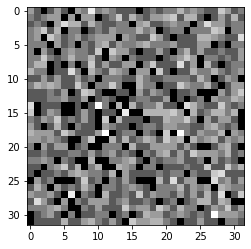

In [23]:

plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
plt.savefig('gen_'+str(imageNum1)+'.png')
plt.show()